In [409]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
# from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup

imp.reload(sp)

mbins = 1000

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [2]:
z_l, dndz_l, zleff = sp.zed.get_dndz_spec(gtype='lens')
rp = setup.arcmin_to_rp(20, zleff, sp.zed.cosmo_SRD) * (sp.pa.HH0 / 100.)
theta_edges = setup.setup_rp_bins(0.2, 25, 10)
theta_cents = setup.rp_bins_mid(theta_edges)
print(theta_cents)
print(rp)

[ 0.25461002  0.41263541  0.6687403   1.08379839  1.756465    2.8466266
  4.61340417  7.47674391 12.11723433 19.63787576]
10.138759220905907


## We start with the case where there is no Intrinsic Alignment

First get F($\theta$) using dependance from Sara $\Pi_{close} = r_{p} ; r_{p} > 2 : \Pi_{close} = 2Mpch^{-1} ; r_{p} \leq 2Mpch^{-1}$

In [3]:
#F = sp.get_F(theta_dependence=False)
F_theta = sp.get_F(theta_dependence=True)

Check values of F are sensible for both cases. 
We would expect F without theta dependence to be much larger across these scales becuase the projection is 100Mpc h-1, whereas the max projection with theta depedence is ~ 10Mpc h-1

In [4]:
print(F)
print(F_theta)

0.02073898968122842
[0.0006165  0.0006165  0.0006165  0.0006165  0.0006165  0.0006165
 0.00080148 0.00129893 0.00210512 0.00341169]


Next calculate $B(\theta) - 1$ (or load from boost file, comment out accordingly)

In [5]:
#B_min1, theta = sp.get_boosts()
B_min1 = np.load('generated_data/Boost_data_year1.npz')['B_min1']
theta = np.load('generated_data/Boost_data_year1.npz')['theta']

In [6]:
print(B_min1)
print(theta)

[0.09429856 0.05354952 0.03250654 0.02241816 0.0159059  0.01095674
 0.00716792 0.00437449 0.00244329 0.00122134]
[ 0.25461002  0.41263541  0.6687403   1.08379839  1.756465    2.8466266
  4.61340417  7.47674391 12.11723433 19.63787576]


For LSST we have the multiplicative bias requirements:

Y1 $\Delta m \leq 0.013$

Y10 $\Delta m \leq 0.003$

In [798]:
# year 1 mbias
delM_max = 0.013
delM_minus_delMp = np.linspace(0., 2.*delM_max, 1000)

# year 10 mbias
# delM_max = 0.003
# delM_minus_delMp = np.linspace(0., 2.*delM_max, 1000)

#### Next get $\gamma_{t}$ for a range of $\Delta m$

Assumptions:
- Define scale factors in gM power spectrum as lens scale factors

In [420]:
ell = np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 180/(theta[0]/60.) + 10, 1024).astype(int))

# compute angular power spectrum for galaxy-galaxy lensing
Cl_gM, tracer1, tracer2 = sp.get_LSST_Cl(ell, 'gm')

### Now we combine everything on the LHS to get RHS for different combinations of $\Delta m$
$\frac{\tilde{\gamma}_{t} - \tilde{\gamma}_{t}^{\prime}}{B(\theta) - 1 + F} = 
    (\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}(\theta)$
    
IA acts radially so detracts from lensing signal. Therefore we take most from least contaminated

In [799]:
gammat = sp.get_gammat_noIA(Cl_gM, theta, ell)
delM_yL_PA = np.zeros([1000, len(theta)])  
for i in range(1000):
        delM_yL_PA[i,:] = delM_minus_delMp[i] * (gammat /  (B_min1 + F_theta))

The rows correspond to bias on gammat, the columns gammat_prime and the 3rd dim is the values for different theta

#### Various plots checking things look sensible

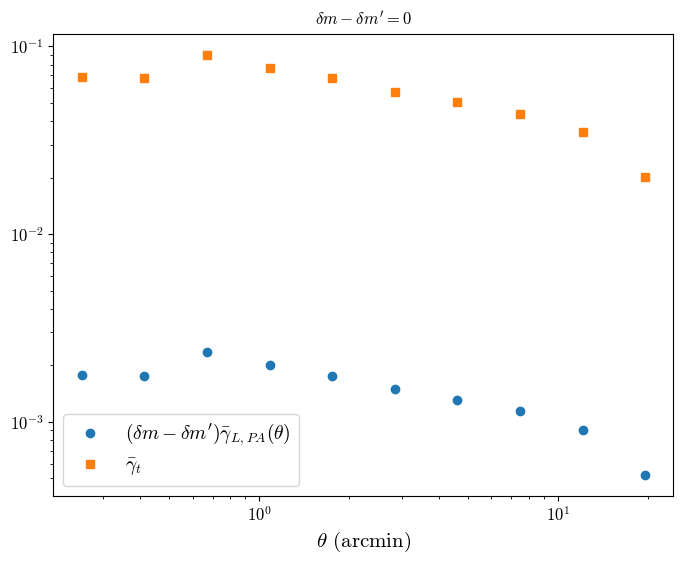

In [896]:
plt.figure(figsize=[8,6])
plt.plot(theta, abs(delM_yL_PA[-1,:]), linewidth=0, marker='o')
plt.plot(theta, gammat/(B_min1 + F_theta), linewidth=0, marker='s')
plt.title(r'$\delta m - \delta m^{\prime} = %g$'%delM_minus_delMp[0])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend([r'$(\delta m - \delta m^{\prime})\bar{\gamma}_{L,PA}(\theta)$',
            r'$\bar{\gamma}_{t}$', r'$\bar{\gamma}_{t}^{\prime}$'],fontsize=14)

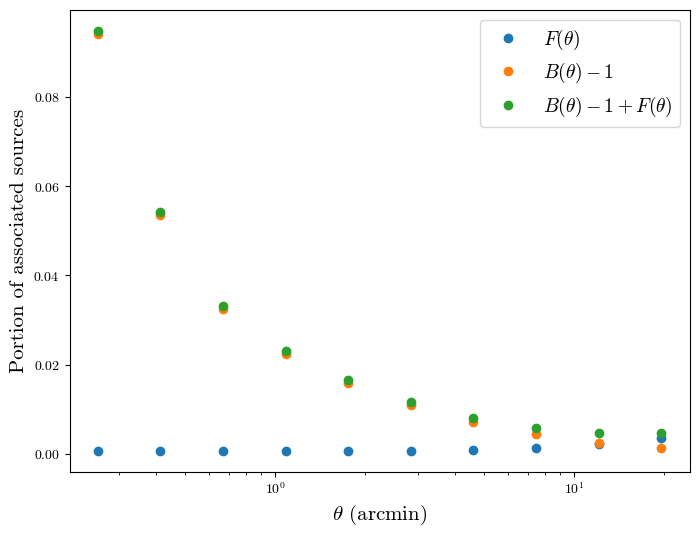

In [14]:
plt.figure(figsize=[8,6])
plt.plot(theta, F_theta, linewidth=0, marker='o')
plt.plot(theta, B_min1, linewidth=0, marker='o')
plt.plot(theta, B_min1 + F_theta, linewidth=0, marker='o')
plt.ylabel(r'Portion of associated sources', fontsize=15)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.xscale('log')
plt.legend([r'$F(\theta)$', r'$B(\theta) - 1$', 
            r'$B(\theta) - 1 + F(\theta)$'], fontsize=14);

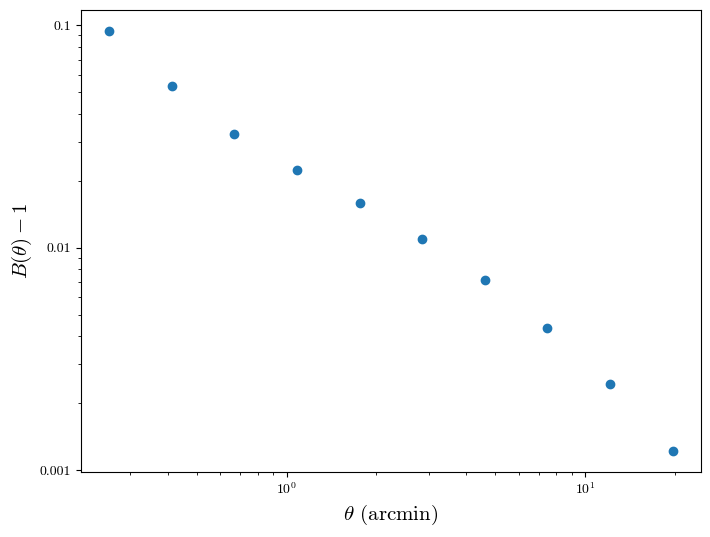

In [15]:
plt.figure(figsize=[8,6])
plt.plot(theta, B_min1, linewidth=0, marker='o')
plt.ylabel(r'$B(\theta) - 1$', fontsize=15)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.xscale('log')
plt.yscale('log')
plt.yticks([1E-1,1E-2,1E-3], ['0.1','0.01','0.001']);

### Lets try some theortetical IA modelling with CCL
- Take $\bar{A}_{IA} = 5.$ and $\sigma_{A} = 3.9$ from SRD
- $f_{red} = 0.16$ from L2018
- A should be a function of redshift, but for now we will assume it is unrealted to the redshift (DISCUSS WITH DANIELLE)
- Let's assume a pessimistic a = 0.65 (Singh 2016)

In [354]:
z_l, dndz_l, zleff = sp.zed.get_dndz_spec('source')
z_s, dndz_s, zseff = sp.zed.get_dndz_spec('lens')

A_IA = 0.16 * 5. * np.ones(len(z_l))

lensTracer = ccl.NumberCountsTracer(sp.halo.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                    bias=(z_l, sp.lens_bias(z_l)))
intrinsicTracer = ccl.WeakLensingTracer(sp.halo.cosmo_SRD, (z_s, dndz_s), has_shear=False, 
                                     ia_bias=(z_s, A_IA))

In [355]:
# defined to be same as in boost function
k_arr = np.geomspace(1E-4, 5E2, 3000)

a_l = 1. / (1. + z_l)

# create 2D power spectrum objects for galaxy-IA correlation
pk_gMf = sp.halo.get_Pk2D('gm', k_arr, np.flip(a_l))

# compute aps for galaxy-intrinsicshape
Cl_IA = ccl.angular_cl(sp.halo.cosmo_SRD, lensTracer, intrinsicTracer, ell, p_of_k_a=pk_gMf)

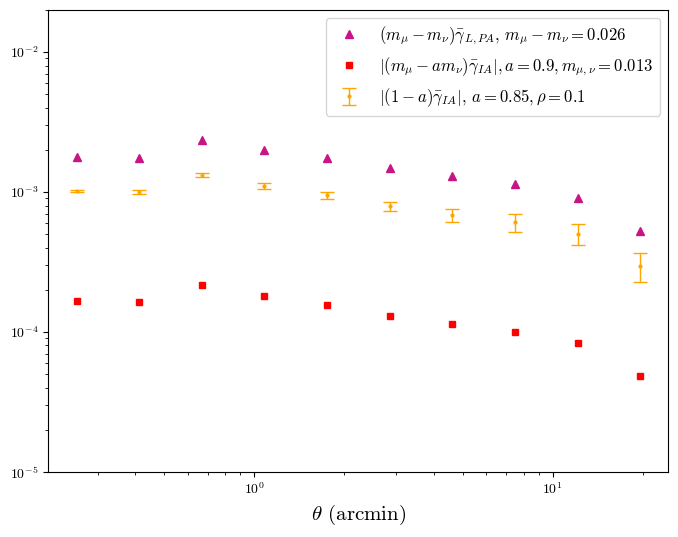

In [1313]:
y_IA = ccl.correlation(sp.halo.cosmo_SRD, ell, Cl_IA, theta / 60., type='NG')
bar_yIA = y_IA / (B_min1 + F_theta)

i = -1

a = 0.85
yIA_1mina = (1.-a)*bar_yIA

CovMats = np.load('generated_data/lsst-y1-covmats-IA.npz')['cov']
IA_sig = np.sqrt(np.diag(CovMats[0])/ (B_min1 + F_theta)**2) 

plt.figure(figsize=[8,6])
plt.errorbar(theta, -yIA_1mina, IA_sig, linewidth=0, marker='o', markersize=2., color='orange',
            elinewidth=1., capsize=5.)
plt.plot(theta, delM_yL_PA[i,:], linewidth=0, marker='^', color='mediumvioletred')
plt.plot(theta, -(0.013+0.9*0.013)*bar_yIA, lw=0., marker='s', markersize=5., color='red')
#plt.errorbar(theta, abs(-yIA_1mina-delM_yL_PA[i,:]), IA_sig, lw=0., marker='x', markersize=5., color='lightseagreen',
#            elinewidth=1., capsize=5.)
plt.xscale('log')
plt.yscale('log')
plt.ylim([1E-5, 2E-2])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.legend([r'$(m_\mu - m_\nu)\bar{\gamma}_{L,PA}$, $m_\mu - m_\nu = %g$'%delM_minus_delMp[i],
            r'$|(m_\mu - am_\nu)\bar{\gamma}_{IA}|, a=%g, m_{\mu,\nu}=%g$'%(0.9,m_mu[-1]),
            r'$|(1-a)\bar{\gamma}_{IA}|$, $a=%g,\rho=%g$'%(a,0.1)], 
           fontsize=12)
plt.savefig('IA_vs_artefact_forecast_prelim.png', dpi=300)

In [1281]:
a_off = np.linspace(0.1, 0.9, 1000)

yIA_of_a = np.zeros([len(a_off),len(bar_yIA)])
for i in range(len(a_off)):
    yIA_of_a[i,:] = -(1.-a_off[i])*bar_yIA[:]
        
SNR = np.zeros([len(a_off),len(delM_minus_delMp)])
for i in range(len(a_off)):
    for j in range(len(delM_minus_delMp)-1):
        SNR[i,j] = np.mean((yIA_of_a[i,:]) / delM_yL_PA[j+1,:])

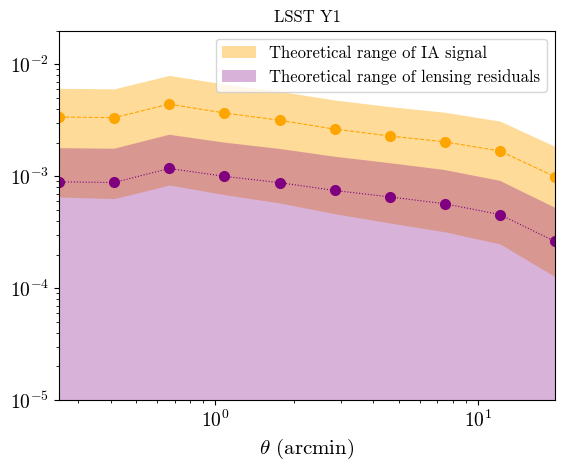

In [1282]:
rho = np.load('generated_data/lsst-y1-covmats-IA.npz')['rho']
i = 0

IA_sigMax = np.sqrt(np.diag(CovMats[i])) / (B_min1 + F_theta)
IA_min = yIA_of_a[-1,:] - IA_sigMax[:]
IA_max = yIA_of_a[1,:] + IA_sigMax[:]
IA_mid = yIA_of_a[499,:]

resi_min = delM_yL_PA[0,:]
resi_max = delM_yL_PA[-1,:]
resi_mid = delM_yL_PA[499,:]

fig, ax = plt.subplots()

IA_range = ax.fill_between(theta, IA_min, IA_max,alpha=0.4,color='orange',lw=0.)
ax.plot(theta, IA_mid,color='orange', markersize=7., marker='o', linestyle='--',lw=0.8)

residual_range = ax.fill_between(theta, resi_min, resi_max, alpha=0.3, color='purple',lw=0.)
ax.plot(theta, resi_mid,color='purple', markersize=7., marker='o', linestyle='dotted',lw=0.8)

ax.plot(theta, )

plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim([1E-5, 2E-2])
plt.xlim([theta.min(),theta.max()])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)
plt.legend(handles=[IA_range, residual_range],labels=['Theoretical range of IA signal', 'Theoretical range of lensing residuals'], fontsize=12)
plt.title(r'LSST Y1')
plt.savefig('All_IA_vs_All_residual_Y1.png', bbox_inches='tight', dpi=300.)

In [954]:
chi2_diff = np.zeros([len(a_off),len(mdiff)])

for i in range(len(a_off)):
    for j in range(len(mdiff)):
        diff = yIA_of_a[i,:] - delM_yL_PA[j,:]
        chi2_diff[i,j] = np.sqrt(diff.T @ np.linalg.inv(CovMats[0]) @ diff)

In [ ]:
A,M = np.meshgrid(a_off,delM_minus_delMp)        
        
fig, ax = plt.subplots()

snr1 = ax.contour(A,M,chi2_diff,[1],linestyles='solid', linewidths=2., colors='white')
snr2 = ax.contour(A,M,chi2_diff,[2], linestyles='--', linewidths=2., colors='white')

cax = ax.imshow(np.flip(chi2_diff,axis=0), extent=[a_off[0],a_off[-1],delM_minus_delMp[0],delM_minus_delMp[-1]], aspect='auto', cmap='inferno'
                , norm=mpl.colors.LogNorm())

cbar = fig.colorbar(cax)
#cbar.set_label(r'$\chi^2_{IA}/\chi^2_{L,PA}$', fontsize=14)
plt.xlabel(r'$a$', fontsize=14)
plt.ylabel(r'$|m_\mu - m_\nu|$', fontsize=14)
plt.title(r'LSST Y1, $A_{IA} = 5.0$, $f_{red}=0.16$', fontsize=14)
plt.ylim([0.,0.026])
plt.savefig('chi2_ratio_colorbar.png',dpi=300)

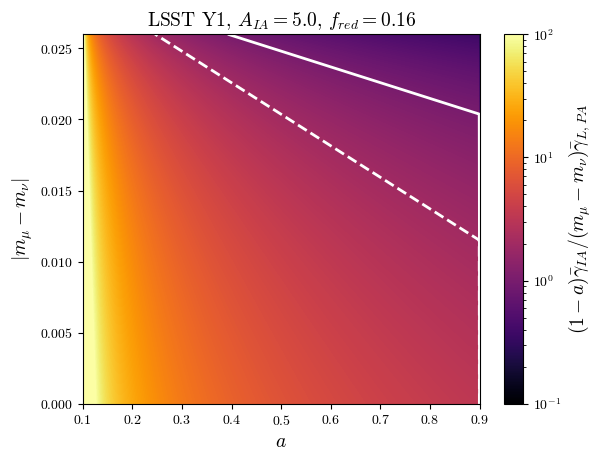

In [1283]:
A,M = np.meshgrid(a_off,delM_minus_delMp)        
        
fig, ax = plt.subplots()

snr1 = ax.contour(A,M,SNR,[1],linestyles='solid', linewidths=2., colors='white')
snr2 = ax.contour(A,M,SNR,[2], linestyles='--', linewidths=2., colors='white')

cax = ax.imshow(np.flip(SNR,axis=0), extent=[a_off[0],a_off[-1],delM_minus_delMp[0],delM_minus_delMp[-1]], aspect='auto', cmap='inferno'
                , norm=mpl.colors.LogNorm(vmin=0.1, vmax=100.))

cbar = fig.colorbar(cax)
cbar.set_label(r'$(1-a)\bar{\gamma}_{IA}/(m_\mu - m_\nu)\bar{\gamma}_{L,PA}$', fontsize=14)
plt.xlabel(r'$a$', fontsize=14)
plt.ylabel(r'$|m_\mu - m_\nu|$', fontsize=14)
plt.title(r'LSST Y1, $A_{IA} = 5.0$, $f_{red}=0.16$', fontsize=14)
plt.ylim([0.,0.026])
plt.savefig('IAvsResidual_colorbar.png',dpi=300)

## Do we measure a signal if there is no IA?

- Treat lensing artefact as IA signal, calculate SNR for COVARIANCES

In [645]:
CovFile = np.load('generated_data/lsst-y1-covmats-NoIA.npz')

rho = CovFile['rho']
CovMats = CovFile['cov']

print(rho)
print(np.shape(CovMats))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
(9, 10, 10)


In [646]:
residual = delM_yL_PA
mdiff = delM_minus_delMp
print(np.shape(mdiff))
print(np.shape(residual))

(1000,)
(1000, 10)


In [768]:
NoIA_SNR = np.zeros([len(rho),len(mdiff)])
    
for i in range(len(rho)):
    inv_cov = np.linalg.inv(CovMats[i])/(B_min1 + F)
    for j in range(len(mdiff)):
        
        NoIA_SNR[i,j] = np.sqrt(residual[j,:].T @ inv_cov @ residual[j,:])

        #snr[i] = np.sqrt(residual[i,:].T @ np.linalg.inv(no_cov) @ residual[i,:])

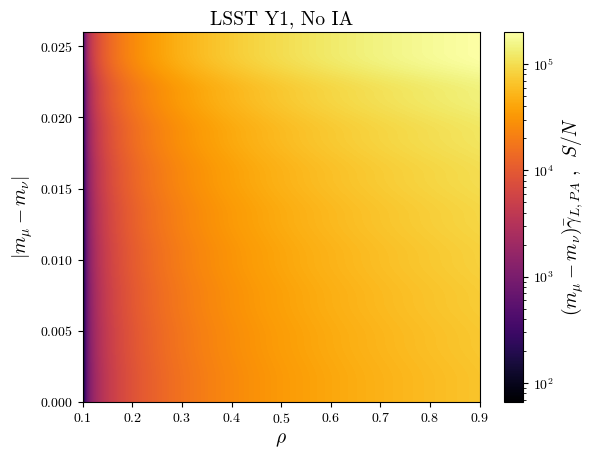

In [1284]:
DM,RHO = np.meshgrid(mdiff,rho)        

fig, ax = plt.subplots()

# need to flip becuase SNR starts at mdiff = -0.026
cax = ax.imshow(np.flip(NoIA_SNR,axis=0), extent=[rho[0],rho[-1],mdiff[0],mdiff[-1]], aspect='auto', 
           norm=mpl.colors.LogNorm(), cmap='inferno')

cbar = fig.colorbar(cax)
cbar.set_label(r'$(m_\mu - m_\nu)\bar{\gamma}_{L,PA} \,\, , \,\,\, S/N$', fontsize=14)
plt.xlabel(r'$\rho$', fontsize=14)
plt.ylabel(r'$|m_\mu - m_\nu|$', fontsize=14)
plt.title('LSST Y1, No IA', fontsize=14)
plt.ylim([0,0.026])
plt.savefig('residual_detection.png',dpi=300)

### Treating lensing residual as a systematic uncertainty.
- Initially we will just consider it without covaraince and add it in quadrature to the diagonal elements

In [1286]:
# start with simple consideration for fixed mbias - worst case
k = 0

stat_cov = CovMats[k] / (B_min1 + F)
sys_var = delM_yL_PA[-1,:]

full_cov = np.zeros_like(stat_cov)
for i in range(len(theta)):
    for j in range(len(theta)):
        if i==j:
            full_cov[i,j] = stat_cov[i,j] + sys_var[i]**2
        else:
            full_cov[i,j] = stat_cov[i,j]
            
a = 0.1
yIA_1mina = (1.-a)*bar_yIA

IA_sig = np.sqrt(np.diag(full_cov))

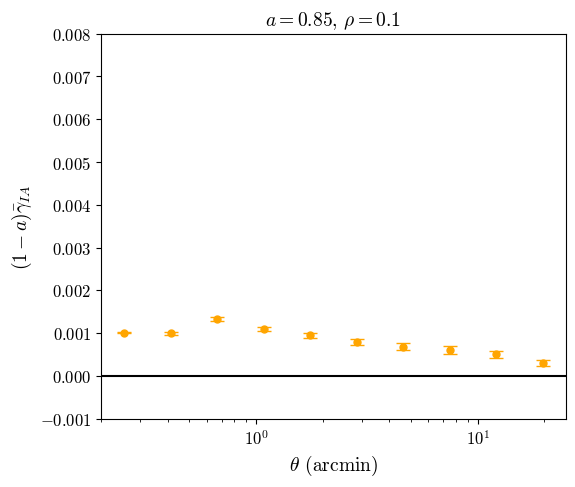

In [1309]:
plt.figure(figsize=[6,5])
plt.errorbar(theta, -yIA_1mina, IA_sig, linewidth=0, marker='o', markersize=5., color='orange',
            elinewidth=1., capsize=5.)
plt.xscale('log')
plt.hlines(y=0.,xmin=0.1*theta.min(),xmax=1.5*theta.max(), color='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.yscale('log')
plt.ylim([-1E-3, 8E-3])
plt.xlim(0.2,25)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}$', fontsize=14)
plt.title(r'$a=%g$, $\rho=%g$'%(a,rho[k]), fontsize=14)
plt.savefig('systematic_errorbar_compare_rho-Y1.png',bbox_inches='tight',dpi=300)

### Now we are going add to the off diagonal elements to compute a signal to noise ratio

In [1234]:
# get IA signals
a_off = np.linspace(0.1, 0.9, 1000)

yIA_of_a = np.zeros([len(a_off),len(bar_yIA)])
for i in range(len(a_off)):
    yIA_of_a[i,:] = (1.-a_off[i])*bar_yIA[:]

# define uncertainties matrices 
stat_cov = CovMats[0] / (B_min1 + F)

# add systematic to covaraince in quadrature
full_cov = np.zeros([len(theta),len(theta),len(delM_yL_PA)])
for k in range(len(delM_yL_PA)):
    sys_var = delM_yL_PA[k,:]
    for i in range(len(theta)):
        for j in range(len(theta)):
            if i==j:
                full_cov[i,j,k] = np.sqrt(stat_cov[i,j]**2 + sys_var[i]**2)
            else:
                full_cov[i,j,k] = stat_cov[i,j]
               
            
# compute S/N for IA measurement at different a and different m
SNR = np.zeros([len(a_off),len(delM_minus_delMp)])

for j in range(len(delM_minus_delMp)):
    inv_cov = np.linalg.inv(full_cov[:,:,j])
    for i in range(len(a_off)):
        SNR[i,j] = np.sqrt(yIA_of_a[i,:].T @ inv_cov @ yIA_of_a[i,:])

(0.0, 0.026)

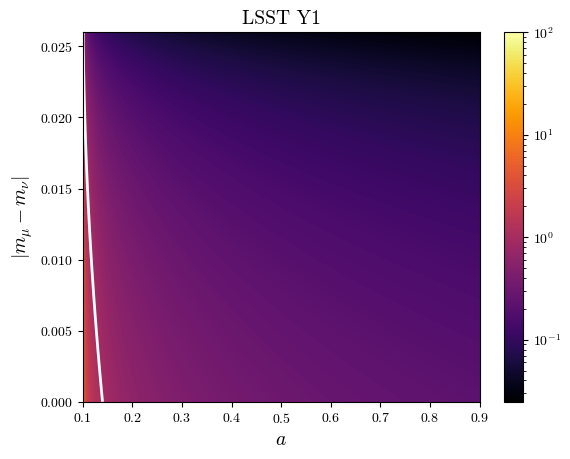

In [1235]:
A,M = np.meshgrid(a_off,delM_minus_delMp)        
        
fig, ax = plt.subplots()

snr1 = ax.contour(A,M,SNR,[1],linestyles='solid', linewidths=2., colors='white')
#snr2 = ax.contour(A,M,SNR,[2], linestyles='--', linewidths=2., colors='white')

cax = ax.imshow(np.flip(SNR,axis=0), extent=[a_off[0],a_off[-1],delM_minus_delMp[0],delM_minus_delMp[-1]], aspect='auto', cmap='inferno'
                , norm=mpl.colors.LogNorm(vmax=100))

cbar = fig.colorbar(cax)
plt.xlabel(r'$a$', fontsize=14)
plt.ylabel(r'$|m_\mu - m_\nu|$', fontsize=14)
plt.title(r'LSST Y1', fontsize=14)
plt.ylim([0.,0.026])

/tmp/ipykernel_49183/1156008714.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([-1E-3, 1.15E-2])


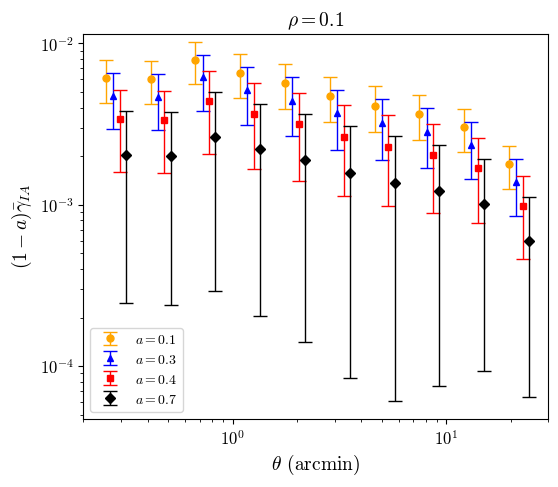

In [1312]:
# start with simple consideration for fixed mbias - worst case
k = 0

stat_cov = CovMats[k] / (B_min1 + F_theta)**2
sys_var = delM_yL_PA[-1,:]

full_cov = np.zeros_like(stat_cov)
for i in range(len(theta)):
    for j in range(len(theta)):
        if i==j:
            full_cov[i,j] = stat_cov[i,j] + sys_var[i]**2
        else:
            full_cov[i,j] = stat_cov[i,j]

IA_sig = np.sqrt(np.diag(full_cov))

a = [0.1,0.3,0.5,0.7]
logshift = np.zeros([len(a),len(bar_yIA)])
yIA_1mina = np.zeros([len(a),len(bar_yIA)])
for i in range(len(a)):
    yIA_1mina[i,:] = -(1.-a[i]) * bar_yIA[:]
    logshift[i,:] = 0.08*theta*i

plt.figure(figsize=[6,5])
plt.errorbar(theta+logshift[0], yIA_1mina[0], IA_sig, linewidth=0, marker='o', markersize=5., color='orange',
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[1], yIA_1mina[1], IA_sig, linewidth=0, marker='^', markersize=5., color='blue',
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[2], yIA_1mina[2], IA_sig, linewidth=0, marker='s', markersize=5., color='red',
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[3], yIA_1mina[3], IA_sig, linewidth=0, marker='D', markersize=5., color='black',
            elinewidth=1., capsize=5.)
plt.legend([r'$a=0.1$',r'$a=0.3$',r'$a=0.4$',r'$a=0.7$'])

plt.hlines(y=0.,xmin=0.1*theta.min(),xmax=1.6*theta.max(), color='black')
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.ylim([-1E-3, 1.15E-2])
plt.xlim(0.2,30)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}$', fontsize=14)
plt.title(r'$\rho=%g$'%(rho[k]), fontsize=14)
plt.savefig('Y1_different_a_comparison-rho=0.1.png', bbox_inches='tight', dpi=300)